In [8]:
import torch
from tqdm import trange
from torch_geometric.datasets import TUDataset
%load_ext autoreload
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGPooling, TopKPooling
from torch_geometric.nn import global_mean_pool


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Reload when files are changed
import CayleyNet

import importlib
importlib.reload(CayleyNet)

ModuleNotFoundError: No module named 'CayleyNet'

In [10]:
# See the usage of the GPU
!nvidia-smi

Fri Dec  8 21:12:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   28C    P0    36W / 250W |    723MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   

## Load MUTAG dataset

In [4]:

# Ceck if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

dataset_MUTAG = dataset

Using device: cuda

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/home/infres/jalvarez-22/miniconda3/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/home/infres/jalvarez-22/miniconda3/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


## Load Cora dataset

In [11]:
# Load cora dataset
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='data/Planetoid', name='Cora')
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

dataset_Cora = dataset


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


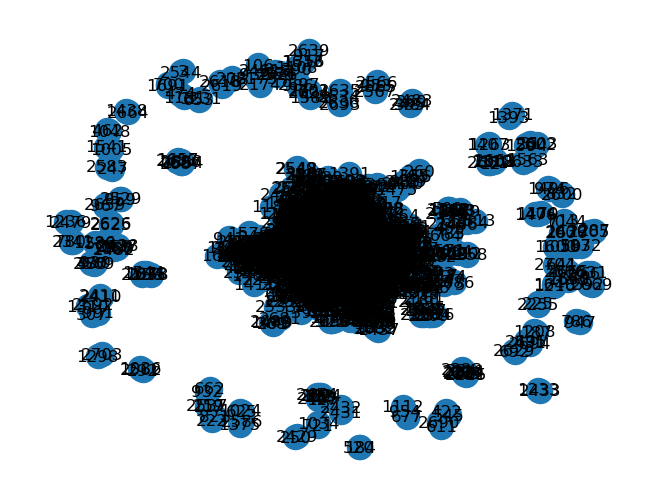

In [5]:
# Visualize the graph
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx
G = to_networkx(data, to_undirected=True)
nx.draw(G, with_labels=True)
plt.show()


In [6]:
dataset = dataset_MUTAG

plt.figure(figsize=(6, 6))
plt.subplot(111)
nx.draw(to_networkx(dataset[5]), with_labels=True)
plt.show()

# plot class distribution
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(dataset):
    plt.figure(figsize=(6, 3))
    plt.hist(dataset.data.y, bins=dataset.num_classes, rwidth=0.7)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(dataset.num_classes))
    plt.show()

plot_class_distribution(dataset)



NameError: name 'dataset_MUTAG' is not defined

## Define CayleyNet

In [9]:
reload(CayleyNet)

Using device: cpu


<module 'CayleyNet' from '/home/infres/avalenca-22/CayleyNets/CayleyNet/CayleyNet.py'>

In [10]:
from CayleyNet import CayleyConv
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, r=64, sparse = False, dropout = 0.5, normalizartion = 'sym', bias = True):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = CayleyConv(num_node_features, hidden_channels, r, normalization = normalizartion, bias = bias, sparse = sparse)
        self.pool = TopKPooling(hidden_channels, ratio=0.9)
        self.conv2 = CayleyConv(hidden_channels, hidden_channels, r, normalization = normalizartion, bias = bias, sparse = sparse)
        self.lin = Linear(hidden_channels, num_classes)
        self.sparse = sparse
        self.dropout = dropout
        self.normalizartion = normalizartion
        self.bias = bias


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x, edge_index, _, batch, _, _ =  self.pool(x, edge_index)
    
        x = global_mean_pool(x, batch) 
        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin(x)
        
        return F.log_softmax(x.float(), dim=-1)

In [10]:
dataset = dataset_MUTAG

# Hyperparameters
batch_size = 32
num_epochs = 100
learning_rate = 5e-3
hidden_channels = 16
weight_decay = 5e-4
poly_order = 5
num_node_features = dataset.num_features
num_classes = dataset.num_classes
sparse = False

# Create model
model = GCN(hidden_channels, num_node_features, num_classes, poly_order, sparse, normalizartion= 'rw').to(device)
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
#parameters of the CayleyConv layer
print(f'Number of parameters: {sum(p.numel() for p in model.conv1.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.conv2.parameters())}')


GCN(
  (conv1): CayleyConv(7, 16, r=5, normalization=rw)
  (pool): TopKPooling(16, ratio=0.9, multiplier=1.0)
  (conv2): CayleyConv(16, 16, r=5, normalization=rw)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)
Number of parameters: 4484
Number of parameters: 1425
Number of parameters: 3009


In [11]:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss().to(device)
train_dataset = dataset[:150]
test_dataset = dataset[150:]
sparse = True
# data to device
train_dataset.data = train_dataset.data.to(device)
test_dataset.data = test_dataset.data.to(device)





/home/infres/jalvarez-22/miniconda3/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [12]:
# Save the loss values for plotting
loss_values = []
#loss by epoch
loss_values_epoch = []
# Your training loop
model.train()
for epoch in trange(num_epochs):
    j = 0
    loss_values = []
    for data in train_dataset: 
        #data = data.to(device)
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y) 
        loss_values.append(loss.item())
        loss.backward() 
        optimizer.step() 
        optimizer.zero_grad() 
        # Overwrite the printed loss value
        print(f'\rEpoch: {epoch}, data: {j}, Loss: {loss.item():.4f}', end='')
        j += 1
    loss_values_epoch.append(np.mean(loss_values))


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, data: 141, Loss: 0.3421

  1%|          | 1/100 [00:04<07:47,  4.73s/it]

Epoch: 1, data: 29, Loss: 0.05997

  1%|          | 1/100 [00:05<09:34,  5.80s/it]

Epoch: 1, data: 37, Loss: 2.4178

KeyboardInterrupt: 

# CORA


In [15]:
import importlib
import src.CayleyNet as CayleyNet
importlib.reload(CayleyNet)

<module 'src.CayleyNet' from '/home/infres/avalenca-22/CayleyNets/src/CayleyNet.py'>

In [16]:
# We will use the Cora dataset
dataset = dataset_Cora
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dataset[0] 
data = data.to(device)

# Print properties of the data object
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features per node: {data.num_node_features}')
print(f'Number of edge features: {data.num_edge_features}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of edge features: 0
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [17]:

# Hyperparameters
batch_size = 1
num_epochs = 100
learning_rate = 0.01
hidden_channels = 16
poly_order = 5
num_node_features = dataset.num_features
num_classes = dataset.num_classes
sparse = False



In [18]:
# Hyperparameters (Section 4.5)
in_feats = dataset.num_features
n_classes = dataset.num_classes
n_hidden = 16
n_layers = 1 # number of hidden+output layers
r = 5 # Cayley polynomial order 
# obs: we weren't able to identify the value of this last parameter in the paper

In [19]:
model = CayleyNet.CayleyNet(in_feats, n_classes, n_hidden, n_layers, r=5, p_dropout=0.5, normalization = 'sym', sparse=False, seed=0)
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[0].parameters())}')
print(f'Number of parameters: {sum(p.numel() for p in model.layers[1].parameters())}')

CayleyNet(
  (layers): ModuleList(
    (0): CayleyConv(1433, 16, r=5, normalization=sym)
    (1): CayleyConv(16, 7, r=5, normalization=sym)
  )
)
Number of parameters: 23042
Number of parameters: 22929
Number of parameters: 113


/home/infres/avalenca-22/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1148: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


In [20]:
print(device)
train_dataset = data.x[data.train_mask]
test_dataset = data.x[data.test_mask]
val_dataset = data.x[data.val_mask]
train_dataset.data = train_dataset.data.to(device)
test_dataset.data = test_dataset.data.to(device)
val_dataset.data = val_dataset.data.to(device)

y_train = data.y[data.train_mask]
y_test = data.y[data.test_mask]
y_val = data.y[data.val_mask]
y_train = y_train.to(device)
y_test = y_test.to(device)
y_val = y_val.to(device)




cpu


In [21]:
import time

In [22]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [23]:
data.x.shape

torch.Size([2708, 1433])

In [26]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [27]:
data.edge_index.shape

torch.Size([2, 10556])

In [25]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# save loss values for plotting
loss_values = []
for e in range(num_epochs):
    start = time.time()
    # Compute output
    out = model(data.x, data.edge_index)
    # Compute loss
    loss = F.nll_loss(out[data.train_mask], y_train)
    loss_values.append(loss.item())
    # Perform backward pass
    loss.backward()
    # Perform optimization step
    optimizer.step()
    # Reset gradients
    optimizer.zero_grad()
    # Print loss
    end = time.time()
    print(f'Epoch: {e:03d}, Loss: {loss:.4f}, Elapsed time: {end - start:.2f}s')

Epoch: 000, Loss: 2.0724, Elapsed time: 6.99s
Epoch: 001, Loss: 1.8507, Elapsed time: 5.54s


KeyboardInterrupt: 

In [33]:
# Train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# save loss values for plotting
loss_values = []
for e in range(num_epochs):
    start = time.time()
    # Compute output
    out = model(data.x, data.edge_index)
    # Compute loss
    loss = F.nll_loss(out[data.train_mask], y_train)
    loss_values.append(loss.item())
    # Perform backward pass
    loss.backward()
    # Perform optimization step
    optimizer.step()
    # Reset gradients
    optimizer.zero_grad()
    # Print loss
    end = time.time()
    print(f'Epoch: {e:03d}, Loss: {loss:.4f}, Elapsed time: {end - start:.2f}s')
    

Epoch: 000, Loss: 2.1459, Elapsed time: 6.504469633102417s
Epoch: 001, Loss: 1.8751, Elapsed time: 4.838495254516602s
Epoch: 002, Loss: 1.7502, Elapsed time: 4.711791753768921s
Epoch: 003, Loss: 1.6602, Elapsed time: 4.727384090423584s
Epoch: 004, Loss: 1.5516, Elapsed time: 4.964893341064453s
Epoch: 005, Loss: 1.4310, Elapsed time: 4.810664653778076s
Epoch: 006, Loss: 1.3401, Elapsed time: 4.641637086868286s
Epoch: 007, Loss: 1.2310, Elapsed time: 4.624220371246338s
Epoch: 008, Loss: 1.1377, Elapsed time: 4.626358985900879s
Epoch: 009, Loss: 1.0672, Elapsed time: 4.608684539794922s
Epoch: 010, Loss: 0.8686, Elapsed time: 4.696069240570068s
Epoch: 011, Loss: 0.7949, Elapsed time: 4.695581436157227s
Epoch: 012, Loss: 0.6727, Elapsed time: 4.583122968673706s
Epoch: 013, Loss: 0.6078, Elapsed time: 4.791365623474121s
Epoch: 014, Loss: 0.5335, Elapsed time: 4.548194646835327s
Epoch: 015, Loss: 0.5182, Elapsed time: 4.597184658050537s
Epoch: 016, Loss: 0.4054, Elapsed time: 4.67325758934021

In [74]:
# retreeve the convolutionals layers of the model (parameters c_i and c_o)
c1 = model.conv1.c
c2 = model.conv2.c

# Print the parameters
print(c1)
print(c2)


ModuleList(
  (0-4): 5 x CLinear(
    (re_linear): Linear(in_features=1433, out_features=16, bias=True)
    (im_linear): Linear(in_features=1433, out_features=16, bias=True)
  )
)
ModuleList(
  (0-4): 5 x CLinear(
    (re_linear): Linear(in_features=16, out_features=16, bias=True)
    (im_linear): Linear(in_features=16, out_features=16, bias=True)
  )
)


TypeError: Image data of dtype object cannot be converted to float

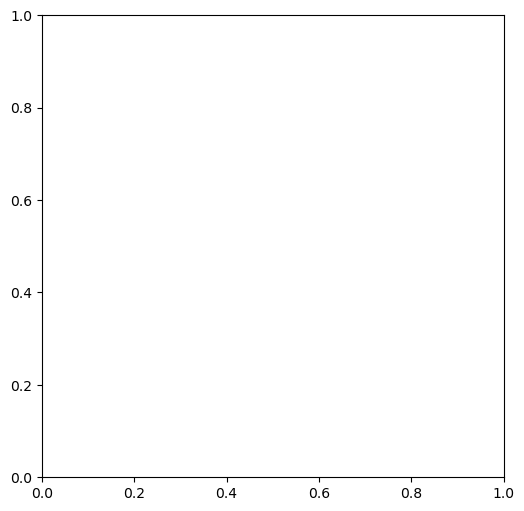

In [77]:
# The CayleyConv is defined as follows:
# X = c_i *(I-)

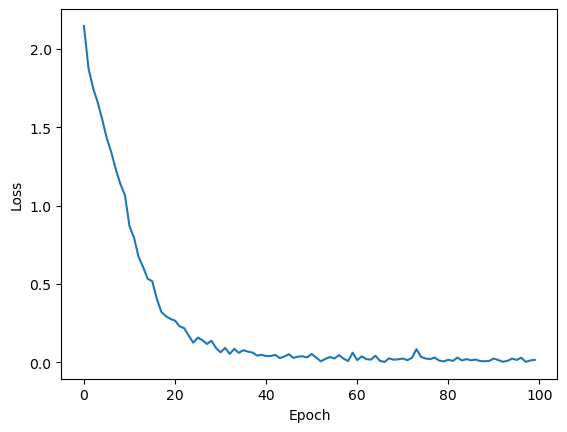

In [34]:
#plot the loss
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()




Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


[False]

In [35]:
model.eval()

data = dataset[0].to(device)
correct = 0

# Compute accuracy on the test set
pred = model(data.x, data.edge_index).argmax(dim=1)
correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
acc = correct / data.test_mask.sum().item()
print(f'Test accuracy: {acc:.4f}')






Test accuracy: 0.6090
